# Google Analytics Revenue Prediction

## Model Selection - COMBINED

**Environment**

In [60]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import eli5
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import mean_squared_error

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Pandas defaults
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500
 
# Make jupyter bigger
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

Using TensorFlow backend.


In [2]:
from myfunctions import *

**Import Dataframe**

In [3]:
df = pd.read_csv("data/df5-3.csv", low_memory=False)

In [4]:
df.shape

(903455, 51)

In [5]:
df.head()

,channel_direct,channel_organic,channel_other,channel_paid,browser_android,browser_chrome,browser_firefox,browser_microsoft,browser_other,cat_desktop,cat_mobile,os_Android,os_Macintosh,os_Windows,os_iOS,continet_Africa,continet_Americas,continet_Asia,continet_Europe,continet_Oceania,ad_GoogleMerchandiseCollection,ad_NoAd,network_Google Search,network_NoAdWords,campaign_AW,campaign_Data Share,campaign_NoCampaign,medium_affiliate,medium_cpc,medium_cpm,medium_none,medium_organic,medium_other,referral_Google,referral_Home,referral_NoReferral,referral_Youtube,source_Google,source_Googleplex,source_Youtube,source_direct,visitNumber,deviceIsMobile,totalsBounces,totalsNewVisits,totalsPageviews,adwordsClickGclId,trafficSourceIsTrueDirect,newRandom,newRevenueDoll,newConversion
0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,1,1,0,0,0.487985,0.0,0
1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,1,1,0,0,0.305608,0.0,0
2,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,1,1,0,0,0.413922,0.0,0
3,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,1,1,0,0,0.174982,0.0,0
4,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,2,1,1,0,1,0,1,0.417494,0.0,0


In [6]:
df.columns

Index(['channel_direct', 'channel_organic', 'channel_other', 'channel_paid',
       'browser_android', 'browser_chrome', 'browser_firefox',
       'browser_microsoft', 'browser_other', 'cat_desktop', 'cat_mobile',
       'os_Android', 'os_Macintosh', 'os_Windows', 'os_iOS', 'continet_Africa',
       'continet_Americas', 'continet_Asia', 'continet_Europe',
       'continet_Oceania', 'ad_GoogleMerchandiseCollection', 'ad_NoAd',
       'network_Google Search', 'network_NoAdWords', 'campaign_AW',
       'campaign_Data Share', 'campaign_NoCampaign', 'medium_affiliate',
       'medium_cpc', 'medium_cpm', 'medium_none', 'medium_organic',
       'medium_other', 'referral_Google', 'referral_Home',
       'referral_NoReferral', 'referral_Youtube', 'source_Google',
       'source_Googleplex', 'source_Youtube', 'source_direct', 'visitNumber',
       'deviceIsMobile', 'totalsBounces', 'totalsNewVisits', 'totalsPageviews',
       'adwordsClickGclId', 'trafficSourceIsTrueDirect', 'newRandom',
       

### Model Selection

In the model selection process I will take into account:<br>
    1.- It is a **binaty classification problem PLUS a Regression Problem**<br>
    2.- The data is Sparse<br>
    3.- The target is very unbalanced (1,29% vs 98,71)<br>
    4.- There is a lot of data 903455 rows and 48 columns<br>

**CONCLUSIONS:**<br>
1.- I'll use a **decision tree** in both cases<br>
2.- I'll try to balance the classes down sampling the data<br>
3.- I'll use Under ROC Curve (AUROC) as metric<br>

### Down sampling the dataframe

I'll separate observations from each class into different DataFrames.


In [7]:
# Separate majority and minority classes
df_majority = df[df.newConversion==0]
df_minority = df[df.newConversion==1]

In [8]:
df_majority.shape

(891940, 51)

In [9]:
df_minority.shape

(11515, 51)

I'll resample the majority class without replacement, setting the number of samples to match that of the minority class.


In [10]:
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=11515,     # to match minority class
                                 random_state=123) # reproducible results
 

I'll combine the down-sampled majority class DataFrame with the original minority class DataFrame.

In [11]:
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])


In [12]:
df_downsampled['newConversion'].value_counts()

1    11515
0    11515
Name: newConversion, dtype: int64

In [13]:
df_downsampled.shape

(23030, 51)

In [14]:
df_downsampled.isnull().sum().sum()

0

*Dataset for the classification**: All the columns EXCEPT the **'newRevenueDoll'**

In [15]:
selected_cols = ['channel_direct', 'channel_organic', 'channel_other', 'channel_paid',
       'browser_android', 'browser_chrome', 'browser_firefox',
       'browser_microsoft', 'browser_other', 'cat_desktop', 'cat_mobile',
       'os_Android', 'os_Macintosh', 'os_Windows', 'os_iOS', 'continet_Africa',
       'continet_Americas', 'continet_Asia', 'continet_Europe',
       'continet_Oceania', 'ad_GoogleMerchandiseCollection', 'ad_NoAd',
       'network_Google Search', 'network_NoAdWords', 'campaign_AW',
       'campaign_Data Share', 'campaign_NoCampaign', 'medium_affiliate',
       'medium_cpc', 'medium_cpm', 'medium_none', 'medium_organic',
       'medium_other', 'referral_Google', 'referral_Home',
       'referral_NoReferral', 'referral_Youtube', 'source_Google',
       'source_Googleplex', 'source_Youtube', 'source_direct', 'visitNumber',
       'deviceIsMobile', 'totalsBounces', 'totalsNewVisits', 'totalsPageviews',
       'adwordsClickGclId', 'trafficSourceIsTrueDirect', 'newRandom'
                 ,'newConversion']
df1_downsampled = df_downsampled[selected_cols]

In [16]:
df1_downsampled.head()

,channel_direct,channel_organic,channel_other,channel_paid,browser_android,browser_chrome,browser_firefox,browser_microsoft,browser_other,cat_desktop,cat_mobile,os_Android,os_Macintosh,os_Windows,os_iOS,continet_Africa,continet_Americas,continet_Asia,continet_Europe,continet_Oceania,ad_GoogleMerchandiseCollection,ad_NoAd,network_Google Search,network_NoAdWords,campaign_AW,campaign_Data Share,campaign_NoCampaign,medium_affiliate,medium_cpc,medium_cpm,medium_none,medium_organic,medium_other,referral_Google,referral_Home,referral_NoReferral,referral_Youtube,source_Google,source_Googleplex,source_Youtube,source_direct,visitNumber,deviceIsMobile,totalsBounces,totalsNewVisits,totalsPageviews,adwordsClickGclId,trafficSourceIsTrueDirect,newRandom,newConversion
106412,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,2,1,0,0,7,0,0,0.721088,0
36727,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1,1,0,0,0.835915,0
225787,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,1,1,1,0,0,0.214265,0
574945,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1,1,0,0,0.584681,0
824616,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,1,0,0,0.931768,0


In [17]:
df1_downsampled.shape

(23030, 50)

In [18]:
df1_downsampled.loc[df1_downsampled['newConversion'] == 0].count()[0]

11515

In [19]:
df1_downsampled.loc[df1_downsampled['newConversion'] == 1].count()[0]

11515

### Classification Tree: Random Forrest

First I'll do a classification prediction

#### Split dataframe

In [20]:
X = df1_downsampled.iloc[:,:-1]
y = df1_downsampled.iloc[:,-1:]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  stratify=y, test_size=0.2, random_state=10)

#### Search Grid Cross Validation

In [22]:
rfc = RandomForestClassifier(random_state=10)

In [23]:
#Current parameters of Random Forrest Classifier
print(rfc.get_params())

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 'warn', 'n_jobs': None, 'oob_score': False, 'random_state': 10, 'verbose': 0, 'warm_start': False}


I'll use the following parameters to hypertune the model

n_estimators = number of trees in the foreset<br>
max_features = max number of features considered for splitting a node<br>
max_depth = max number of levels in each decision tree<br>
bootstrap = method for sampling data points (with or without replacement)<br>
criterion = the function to measure the quality of a split

In [24]:
param_grid = { 
    'n_estimators': [10, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,5,7,9],
    'bootstrap' : [True, False],
    'criterion': ['gini', 'entropy']   
}

In [25]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5, verbose=0)

In [26]:
CV_rfc.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=10,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'

In [27]:
CV_rfc.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': 'auto',
 'n_estimators': 10}

In [28]:
rfc_best=RandomForestClassifier(random_state=10, max_features=CV_rfc.best_params_['max_features'], n_estimators=CV_rfc.best_params_['n_estimators'], max_depth=CV_rfc.best_params_['max_depth'], criterion=CV_rfc.best_params_['criterion'], bootstrap=CV_rfc.best_params_['bootstrap'])


In [29]:
rfc_best.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [30]:
y_pred_train=rfc_best.predict(X_train)

In [31]:
y_pred=rfc_best.predict(X_test)

In [32]:
f1_score(y_train, y_pred_train)

0.9611861265554673

In [33]:
f1_score(y_test, y_pred)

0.9569074778200254

In [34]:
cm = confusion_matrix(y_train, y_pred_train)
cm

array([[8615,  597],
       [ 136, 9076]])

In [35]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[2137,  166],
       [  38, 2265]])

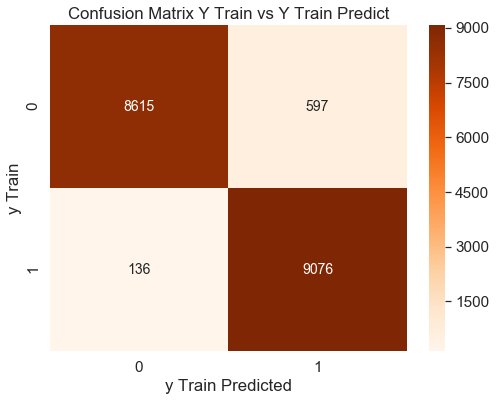

In [36]:
data = confusion_matrix(y_train, y_pred_train)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'y Train'
df_cm.columns.name = 'y Train Predicted'
plt.figure(figsize = (8,6))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Oranges", annot=True,annot_kws={"size": 14},fmt='d')# font size
plt.title("Confusion Matrix Y Train vs Y Train Predict")
plt.show()

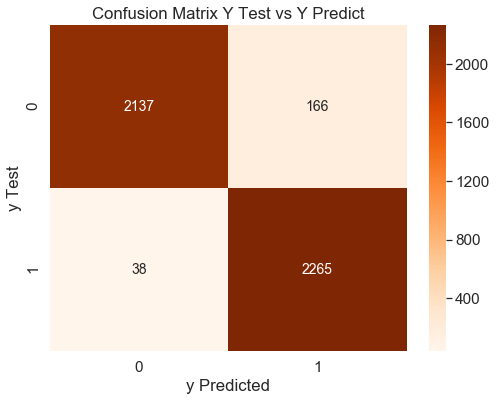

In [37]:
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'y Test'
df_cm.columns.name = 'y Predicted'
plt.figure(figsize = (8,6))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Oranges", annot=True,annot_kws={"size": 14},fmt='d')# font size
plt.title("Confusion Matrix Y Test vs Y Predict")
plt.show()

In [38]:
roc_auc_score(y_test, y_pred)

0.9557099435518888

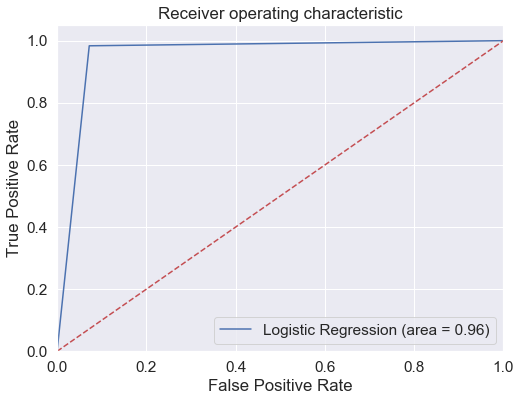

In [39]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(8,6))

plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Regression Tree: Random Forrest

#### Add the predictions to the DataSet

In [40]:
X_train.head()

,channel_direct,channel_organic,channel_other,channel_paid,browser_android,browser_chrome,browser_firefox,browser_microsoft,browser_other,cat_desktop,cat_mobile,os_Android,os_Macintosh,os_Windows,os_iOS,continet_Africa,continet_Americas,continet_Asia,continet_Europe,continet_Oceania,ad_GoogleMerchandiseCollection,ad_NoAd,network_Google Search,network_NoAdWords,campaign_AW,campaign_Data Share,campaign_NoCampaign,medium_affiliate,medium_cpc,medium_cpm,medium_none,medium_organic,medium_other,referral_Google,referral_Home,referral_NoReferral,referral_Youtube,source_Google,source_Googleplex,source_Youtube,source_direct,visitNumber,deviceIsMobile,totalsBounces,totalsNewVisits,totalsPageviews,adwordsClickGclId,trafficSourceIsTrueDirect,newRandom
812504,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,41,0,0,0.674730
561095,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,1,9,0,0,0.063087
21738,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,3,0,0,0.730472
51476,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,2,1,0,0,75,0,1,0.200639
640397,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,12,0,0,0,4,0,1,0.041963


In [41]:
X_train['classPred'] =  y_pred_train

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [42]:
X_train.head()

,channel_direct,channel_organic,channel_other,channel_paid,browser_android,browser_chrome,browser_firefox,browser_microsoft,browser_other,cat_desktop,cat_mobile,os_Android,os_Macintosh,os_Windows,os_iOS,continet_Africa,continet_Americas,continet_Asia,continet_Europe,continet_Oceania,ad_GoogleMerchandiseCollection,ad_NoAd,network_Google Search,network_NoAdWords,campaign_AW,campaign_Data Share,campaign_NoCampaign,medium_affiliate,medium_cpc,medium_cpm,medium_none,medium_organic,medium_other,referral_Google,referral_Home,referral_NoReferral,referral_Youtube,source_Google,source_Googleplex,source_Youtube,source_direct,visitNumber,deviceIsMobile,totalsBounces,totalsNewVisits,totalsPageviews,adwordsClickGclId,trafficSourceIsTrueDirect,newRandom,classPred
812504,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,41,0,0,0.674730,1
561095,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,1,9,0,0,0.063087,0
21738,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,3,0,0,0.730472,0
51476,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,2,1,0,0,75,0,1,0.200639,1
640397,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,12,0,0,0,4,0,1,0.041963,0


In [43]:
X_train.shape

(18424, 50)

In [44]:
X_test.head()

,channel_direct,channel_organic,channel_other,channel_paid,browser_android,browser_chrome,browser_firefox,browser_microsoft,browser_other,cat_desktop,cat_mobile,os_Android,os_Macintosh,os_Windows,os_iOS,continet_Africa,continet_Americas,continet_Asia,continet_Europe,continet_Oceania,ad_GoogleMerchandiseCollection,ad_NoAd,network_Google Search,network_NoAdWords,campaign_AW,campaign_Data Share,campaign_NoCampaign,medium_affiliate,medium_cpc,medium_cpm,medium_none,medium_organic,medium_other,referral_Google,referral_Home,referral_NoReferral,referral_Youtube,source_Google,source_Googleplex,source_Youtube,source_direct,visitNumber,deviceIsMobile,totalsBounces,totalsNewVisits,totalsPageviews,adwordsClickGclId,trafficSourceIsTrueDirect,newRandom
614058,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,31,0,0,0.612875
417799,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,2,1,0,0,2,0,0,0.506749
197282,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,1,4,0,0,0.810542
185927,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,1,2,0,0,0.916766
419191,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,1,1,0,0,0.798793


In [45]:
X_test['classPred'] =  y_pred

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [46]:
X_test.head()

,channel_direct,channel_organic,channel_other,channel_paid,browser_android,browser_chrome,browser_firefox,browser_microsoft,browser_other,cat_desktop,cat_mobile,os_Android,os_Macintosh,os_Windows,os_iOS,continet_Africa,continet_Americas,continet_Asia,continet_Europe,continet_Oceania,ad_GoogleMerchandiseCollection,ad_NoAd,network_Google Search,network_NoAdWords,campaign_AW,campaign_Data Share,campaign_NoCampaign,medium_affiliate,medium_cpc,medium_cpm,medium_none,medium_organic,medium_other,referral_Google,referral_Home,referral_NoReferral,referral_Youtube,source_Google,source_Googleplex,source_Youtube,source_direct,visitNumber,deviceIsMobile,totalsBounces,totalsNewVisits,totalsPageviews,adwordsClickGclId,trafficSourceIsTrueDirect,newRandom,classPred
614058,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,31,0,0,0.612875,1
417799,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,2,1,0,0,2,0,0,0.506749,0
197282,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,1,4,0,0,0.810542,0
185927,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,1,2,0,0,0.916766,0
419191,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,1,1,0,0,0.798793,0


In [47]:
X_test.shape

(4606, 50)

In [48]:
df_downsampled['newRevenueDoll'].shape

(23030,)

In [49]:
y_train = df_downsampled['newRevenueDoll'].iloc[:18424]
y_test = df_downsampled['newRevenueDoll'].iloc[18424:]

In [50]:
y_train.shape

(18424,)

In [51]:
y_test.shape

(4606,)

#### Model


In [74]:
rfr = RandomForestRegressor()

In [75]:
print(rfr.get_params)

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators='warn',
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)>


In [77]:
param_grid = { 
    'n_estimators': [10, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,5,7,9],
    'bootstrap' : [True, False],
}

In [78]:
CV_reg = GridSearchCV(estimator=rfr, param_grid=param_grid, cv= 5, verbose=8)

In [79]:
CV_reg.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] bootstrap=True, max_depth=3, max_features=auto, n_estimators=10 .


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, max_depth=3, max_features=auto, n_estimators=10, score=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=3, max_features=auto, n_estimators=10 .


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  bootstrap=True, max_depth=3, max_features=auto, n_estimators=10, score=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=3, max_features=auto, n_estimators=10 .


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV]  bootstrap=True, max_depth=3, max_features=auto, n_estimators=10, score=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=3, max_features=auto, n_estimators=10 .


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s


[CV]  bootstrap=True, max_depth=3, max_features=auto, n_estimators=10, score=-3.457, total=   0.3s
[CV] bootstrap=True, max_depth=3, max_features=auto, n_estimators=10 .


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s


[CV]  bootstrap=True, max_depth=3, max_features=auto, n_estimators=10, score=-135.965, total=   0.3s
[CV] bootstrap=True, max_depth=3, max_features=auto, n_estimators=50 .


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s remaining:    0.0s


[CV]  bootstrap=True, max_depth=3, max_features=auto, n_estimators=50, score=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=3, max_features=auto, n_estimators=50 .


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.2s remaining:    0.0s


[CV]  bootstrap=True, max_depth=3, max_features=auto, n_estimators=50, score=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=3, max_features=auto, n_estimators=50 .


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.9s remaining:    0.0s


[CV]  bootstrap=True, max_depth=3, max_features=auto, n_estimators=50, score=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=3, max_features=auto, n_estimators=50 .
[CV]  bootstrap=True, max_depth=3, max_features=auto, n_estimators=50, score=-3.457, total=   0.6s
[CV] bootstrap=True, max_depth=3, max_features=auto, n_estimators=50 .
[CV]  bootstrap=True, max_depth=3, max_features=auto, n_estimators=50, score=-136.300, total=   0.6s
[CV] bootstrap=True, max_depth=3, max_features=auto, n_estimators=100 
[CV]  bootstrap=True, max_depth=3, max_features=auto, n_estimators=100, score=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=3, max_features=auto, n_estimators=100 
[CV]  bootstrap=True, max_depth=3, max_features=auto, n_estimators=100, score=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=3, max_features=auto, n_estimators=100 
[CV]  bootstrap=True, max_depth=3, max_features=auto, n_estimators=100, score=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=3, max_features=aut

[CV]  bootstrap=True, max_depth=5, max_features=auto, n_estimators=100, score=0.000, total=   2.2s
[CV] bootstrap=True, max_depth=5, max_features=auto, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=auto, n_estimators=100, score=0.000, total=   2.2s
[CV] bootstrap=True, max_depth=5, max_features=auto, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=auto, n_estimators=100, score=-3.454, total=   2.2s
[CV] bootstrap=True, max_depth=5, max_features=auto, n_estimators=100 
[CV]  bootstrap=True, max_depth=5, max_features=auto, n_estimators=100, score=-136.138, total=   1.9s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, n_estimators=10 .
[CV]  bootstrap=True, max_depth=5, max_features=sqrt, n_estimators=10, score=0.000, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=sqrt, n_estimators=10 .
[CV]  bootstrap=True, max_depth=5, max_features=sqrt, n_estimators=10, score=0.000, total=   0.1s
[CV] bootstrap=True, max_depth=5, max_features=sq

[CV]  bootstrap=True, max_depth=7, max_features=sqrt, n_estimators=10, score=0.000, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=sqrt, n_estimators=10 .
[CV]  bootstrap=True, max_depth=7, max_features=sqrt, n_estimators=10, score=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=7, max_features=sqrt, n_estimators=10 .
[CV]  bootstrap=True, max_depth=7, max_features=sqrt, n_estimators=10, score=-3.466, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=sqrt, n_estimators=10 .
[CV]  bootstrap=True, max_depth=7, max_features=sqrt, n_estimators=10, score=-136.258, total=   0.1s
[CV] bootstrap=True, max_depth=7, max_features=sqrt, n_estimators=50 .
[CV]  bootstrap=True, max_depth=7, max_features=sqrt, n_estimators=50, score=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=7, max_features=sqrt, n_estimators=50 .
[CV]  bootstrap=True, max_depth=7, max_features=sqrt, n_estimators=50, score=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=7, max_features=sqrt, 

[CV]  bootstrap=True, max_depth=9, max_features=sqrt, n_estimators=50, score=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=9, max_features=sqrt, n_estimators=50 .
[CV]  bootstrap=True, max_depth=9, max_features=sqrt, n_estimators=50, score=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=9, max_features=sqrt, n_estimators=50 .
[CV]  bootstrap=True, max_depth=9, max_features=sqrt, n_estimators=50, score=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=9, max_features=sqrt, n_estimators=50 .
[CV]  bootstrap=True, max_depth=9, max_features=sqrt, n_estimators=50, score=-3.460, total=   0.4s
[CV] bootstrap=True, max_depth=9, max_features=sqrt, n_estimators=50 .
[CV]  bootstrap=True, max_depth=9, max_features=sqrt, n_estimators=50, score=-136.214, total=   0.3s
[CV] bootstrap=True, max_depth=9, max_features=sqrt, n_estimators=100 
[CV]  bootstrap=True, max_depth=9, max_features=sqrt, n_estimators=100, score=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=9, max_features=sqrt,

[CV]  bootstrap=False, max_depth=3, max_features=sqrt, n_estimators=100, score=0.000, total=   0.4s
[CV] bootstrap=False, max_depth=3, max_features=sqrt, n_estimators=100 
[CV]  bootstrap=False, max_depth=3, max_features=sqrt, n_estimators=100, score=0.000, total=   0.3s
[CV] bootstrap=False, max_depth=3, max_features=sqrt, n_estimators=100 
[CV]  bootstrap=False, max_depth=3, max_features=sqrt, n_estimators=100, score=0.000, total=   0.3s
[CV] bootstrap=False, max_depth=3, max_features=sqrt, n_estimators=100 
[CV]  bootstrap=False, max_depth=3, max_features=sqrt, n_estimators=100, score=-3.455, total=   0.4s
[CV] bootstrap=False, max_depth=3, max_features=sqrt, n_estimators=100 
[CV]  bootstrap=False, max_depth=3, max_features=sqrt, n_estimators=100, score=-136.189, total=   0.4s
[CV] bootstrap=False, max_depth=3, max_features=log2, n_estimators=10 
[CV]  bootstrap=False, max_depth=3, max_features=log2, n_estimators=10, score=0.000, total=   0.0s
[CV] bootstrap=False, max_depth=3, max

[CV]  bootstrap=False, max_depth=5, max_features=sqrt, n_estimators=100, score=-3.456, total=   0.5s
[CV] bootstrap=False, max_depth=5, max_features=sqrt, n_estimators=100 
[CV]  bootstrap=False, max_depth=5, max_features=sqrt, n_estimators=100, score=-136.177, total=   0.5s
[CV] bootstrap=False, max_depth=5, max_features=log2, n_estimators=10 
[CV]  bootstrap=False, max_depth=5, max_features=log2, n_estimators=10, score=0.000, total=   0.0s
[CV] bootstrap=False, max_depth=5, max_features=log2, n_estimators=10 
[CV]  bootstrap=False, max_depth=5, max_features=log2, n_estimators=10, score=0.000, total=   0.0s
[CV] bootstrap=False, max_depth=5, max_features=log2, n_estimators=10 
[CV]  bootstrap=False, max_depth=5, max_features=log2, n_estimators=10, score=0.000, total=   0.1s
[CV] bootstrap=False, max_depth=5, max_features=log2, n_estimators=10 
[CV]  bootstrap=False, max_depth=5, max_features=log2, n_estimators=10, score=-3.457, total=   0.1s
[CV] bootstrap=False, max_depth=5, max_feat

[CV]  bootstrap=False, max_depth=7, max_features=log2, n_estimators=10, score=-3.461, total=   0.1s
[CV] bootstrap=False, max_depth=7, max_features=log2, n_estimators=10 
[CV]  bootstrap=False, max_depth=7, max_features=log2, n_estimators=10, score=-136.143, total=   0.1s
[CV] bootstrap=False, max_depth=7, max_features=log2, n_estimators=50 
[CV]  bootstrap=False, max_depth=7, max_features=log2, n_estimators=50, score=0.000, total=   0.3s
[CV] bootstrap=False, max_depth=7, max_features=log2, n_estimators=50 
[CV]  bootstrap=False, max_depth=7, max_features=log2, n_estimators=50, score=0.000, total=   0.3s
[CV] bootstrap=False, max_depth=7, max_features=log2, n_estimators=50 
[CV]  bootstrap=False, max_depth=7, max_features=log2, n_estimators=50, score=0.000, total=   0.3s
[CV] bootstrap=False, max_depth=7, max_features=log2, n_estimators=50 
[CV]  bootstrap=False, max_depth=7, max_features=log2, n_estimators=50, score=-3.456, total=   0.3s
[CV] bootstrap=False, max_depth=7, max_feature

[CV]  bootstrap=False, max_depth=9, max_features=log2, n_estimators=50, score=0.000, total=   0.4s
[CV] bootstrap=False, max_depth=9, max_features=log2, n_estimators=50 
[CV]  bootstrap=False, max_depth=9, max_features=log2, n_estimators=50, score=0.000, total=   0.4s
[CV] bootstrap=False, max_depth=9, max_features=log2, n_estimators=50 
[CV]  bootstrap=False, max_depth=9, max_features=log2, n_estimators=50, score=-3.461, total=   0.4s
[CV] bootstrap=False, max_depth=9, max_features=log2, n_estimators=50 
[CV]  bootstrap=False, max_depth=9, max_features=log2, n_estimators=50, score=-136.076, total=   0.3s
[CV] bootstrap=False, max_depth=9, max_features=log2, n_estimators=100 
[CV]  bootstrap=False, max_depth=9, max_features=log2, n_estimators=100, score=0.000, total=   0.7s
[CV] bootstrap=False, max_depth=9, max_features=log2, n_estimators=100 
[CV]  bootstrap=False, max_depth=9, max_features=log2, n_estimators=100, score=0.000, total=   0.7s
[CV] bootstrap=False, max_depth=9, max_feat

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  4.5min finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'bootstrap': [True, False], 'ma

In [80]:
CV_reg.best_params_

{'bootstrap': True, 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 10}

In [81]:
regr =RandomForestRegressor(random_state=10, max_features=CV_reg.best_params_['max_features'], n_estimators=CV_reg.best_params_['n_estimators'], max_depth=CV_reg.best_params_['max_depth'], bootstrap=CV_reg.best_params_['bootstrap'])


In [82]:
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=10, verbose=0,
                      warm_start=False)

In [83]:
y_train_pred = regr.predict(X_train)

In [84]:
y_pred = regr.predict(X_test)

In [85]:
print(regr.feature_importances_)

[0.         0.02479633 0.00766822 0.         0.         0.
 0.02550213 0.01774226 0.02407618 0.00575932 0.05945829 0.01545123
 0.00630783 0.02121284 0.         0.02825065 0.01008707 0.01023658
 0.00999696 0.0092516  0.         0.01030441 0.         0.
 0.00419528 0.         0.01012276 0.         0.         0.
 0.01166827 0.         0.03090596 0.         0.01001864 0.
 0.01053209 0.01300393 0.         0.02371711 0.00668078 0.08412987
 0.04390717 0.03151421 0.05588741 0.15676641 0.00961863 0.02473238
 0.14604276 0.04045446]


In [86]:
r2_score(y_train, y_train_pred)

0.0019124052942253167

In [87]:
r2_score(y_test, y_pred)

-83.63717636090186

In [88]:
mean_squared_error(y_train, y_train_pred)

74.92926341563636

In [89]:
mean_squared_error(y_test, y_pred)

125.10293265469949

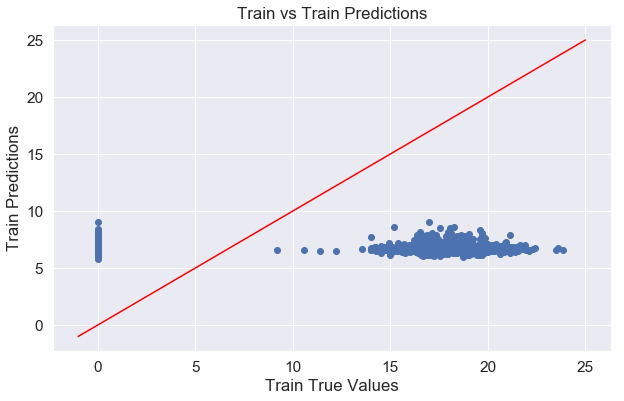

In [90]:
plt.figure(figsize=(10,6))
plt.scatter(y_train, y_train_pred)
plt.plot([-1,25],[-1,25], color='red')
plt.xlabel('Train True Values')
plt.ylabel('Train Predictions')
plt.title('Train vs Train Predictions')
plt.show()

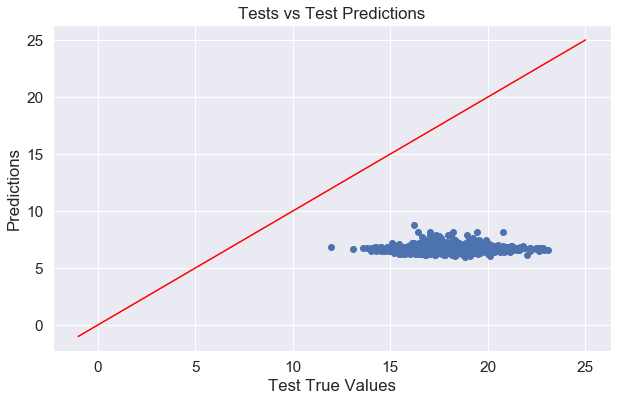

In [91]:
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred)
plt.plot([-1,25],[-1,25], color='red')
plt.xlabel('Test True Values')
plt.ylabel('Predictions')
plt.title('Tests vs Test Predictions')
plt.show()

#### Feature Importance

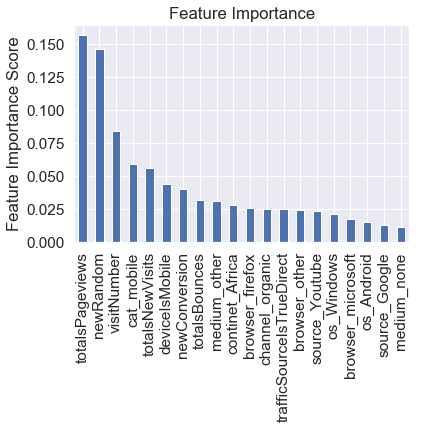

In [92]:
plot_feat_imp(regr,20,df1_downsampled.columns)

In [93]:
print_feat_imp(regr,df1_downsampled)

,Importance,Feature
0,0.1568,totalsPageviews
1,0.1460,newRandom
2,0.0841,visitNumber
3,0.0595,cat_mobile
4,0.0559,totalsNewVisits
5,0.0439,deviceIsMobile
6,0.0405,newConversion
7,0.0315,totalsBounces
8,0.0309,medium_other
9,0.0283,continet_Africa
